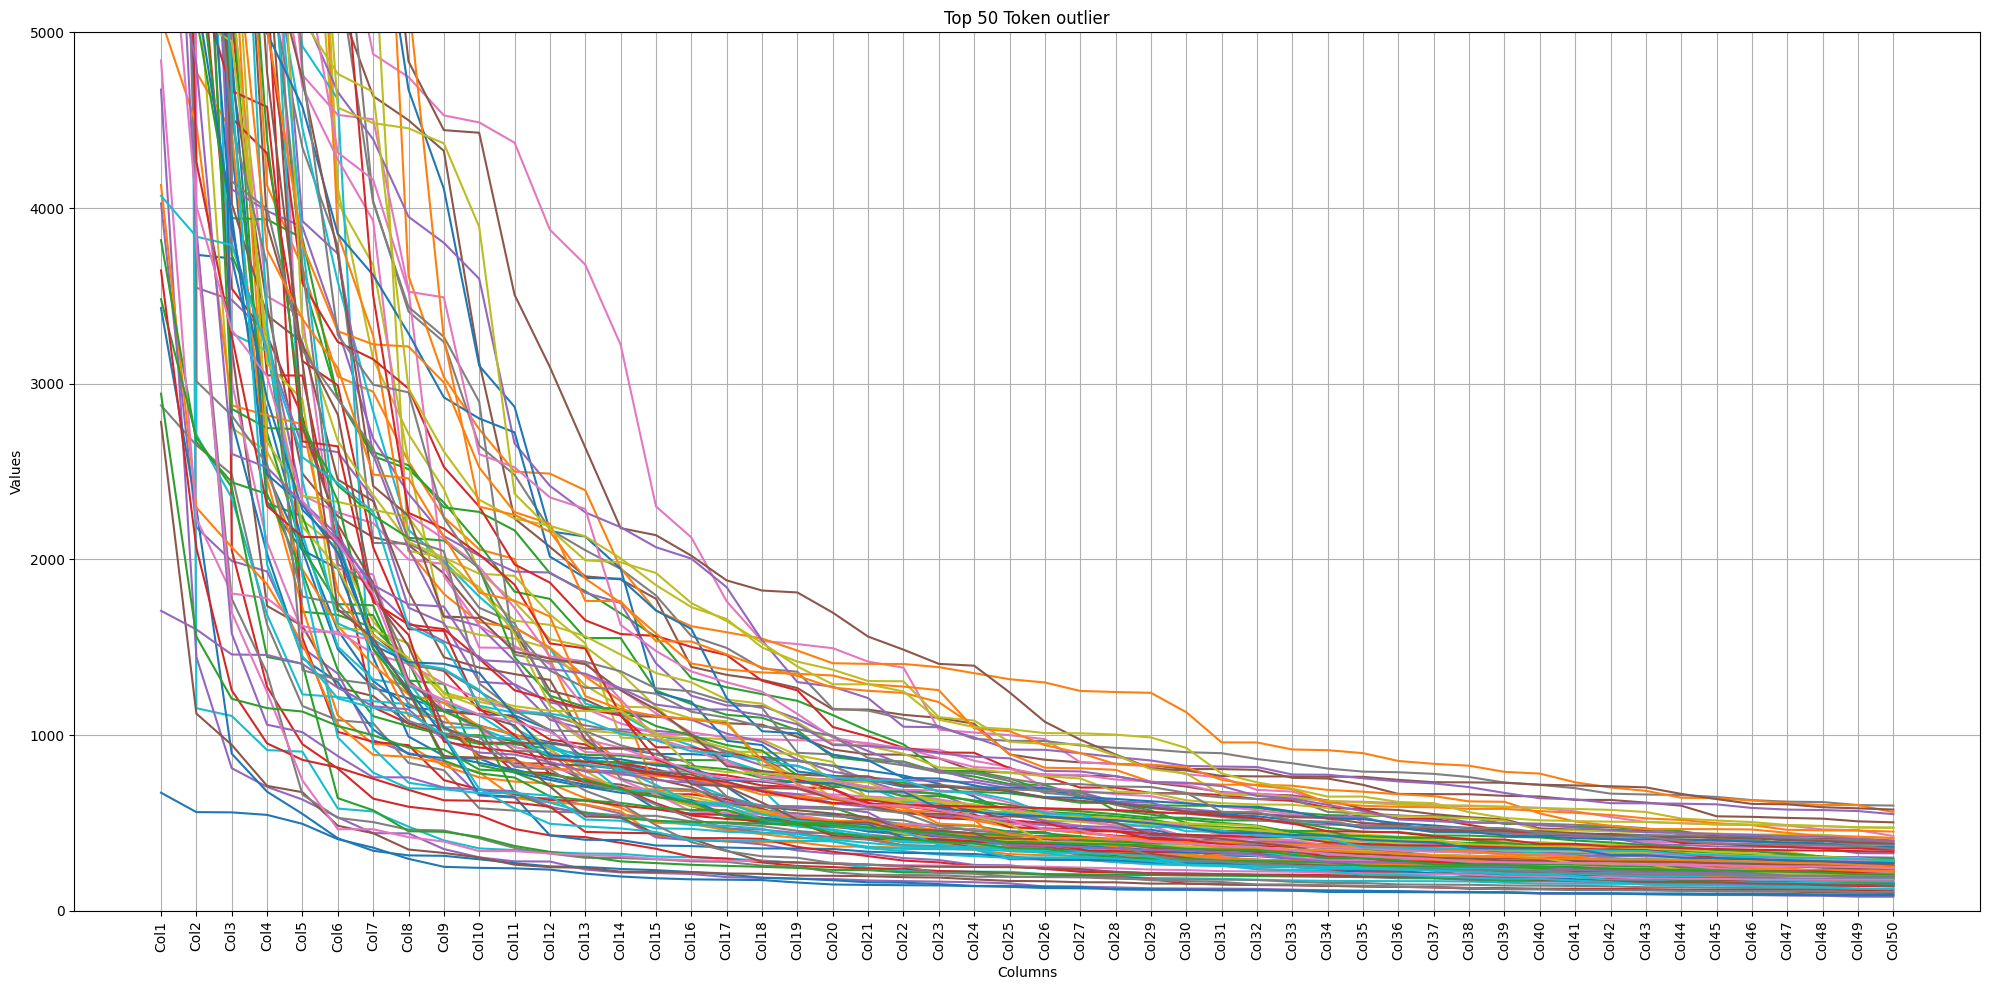

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 경로
file_name = 'block_11_layer_Hidden_State_epoch_2_iteration_1250_min_median_ratios'
file_path = f'/home/shkim/QT_DeiT_small/reproduce/token_probing/token_probing_results_pertensor_wg_fp_with_qk_layernorm/Hidden_State/{file_name}.csv'  # 파일 경로를 실제 파일 경로로 바꿔주세요.

data = pd.read_csv(file_path)
k = 50
# X축 라벨 정의 (Col1 ~ Col197)
x_labels = [f"Col{i}" for i in range(1, k+1)]
x_values = list(range(1, k+1))

# 그래프 크기 설정
plt.figure(figsize=(20, 10))

# 각 행을 선으로 플롯
for index, row in data.iterrows():
    plt.plot(x_values, row[:k], label=f"Row {index}")

# 그래프에 라벨 추가
plt.ylim(0,5000)
plt.xlabel("Columns")
plt.ylabel("Values")
plt.title("Top 50 Token outlier")
plt.xticks(x_values, x_labels, rotation=90)
plt.grid(True)

# 범례 추가 (범례가 너무 많으면 생략 가능)
# plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

# 그래프 출력
plt.tight_layout()
plt.show()




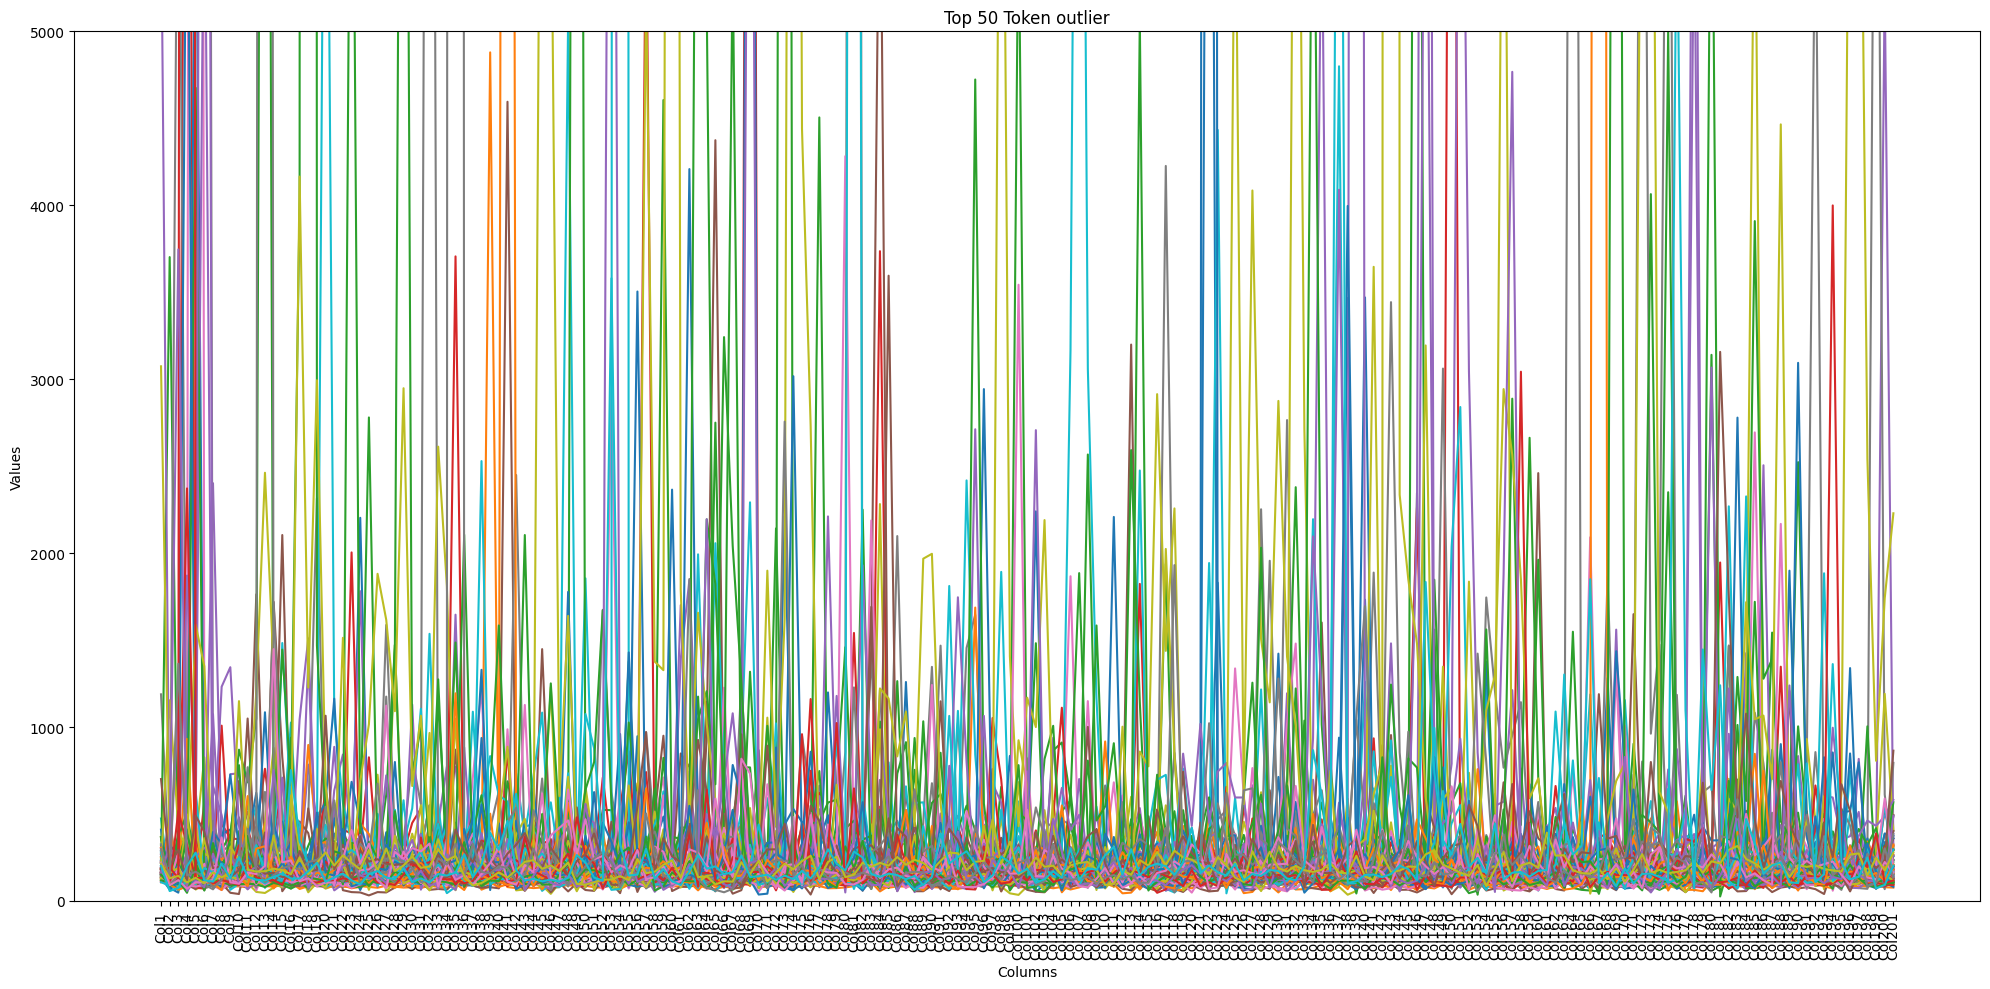

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 경로
file_name = 'block_11_layer_Hidden_State_epoch_14_iteration_1250_min_median_ratios'
file_path = f'/home/shkim/QT_DeiT_small/reproduce/token_probing/token_probing_results_not_sorted_pertensor_wgfp_qkl_mean_CC/Hidden_State/{file_name}.csv'

data = pd.read_csv(file_path)
k = 201
# X축 라벨 정의 (Col1 ~ Col197)
x_labels = [f"Col{i}" for i in range(1, k+1)]
x_values = list(range(1, k+1))

# 그래프 크기 설정
plt.figure(figsize=(20, 10))

# 각 행을 선으로 플롯
for index, row in data.iterrows():
    plt.plot(x_values, row[:k], label=f"Row {index}")

# 그래프에 라벨 추가
# plt.ylim(0,5000)
plt.xlabel("Columns")
plt.ylabel("Values")
plt.title("Top 50 Token outlier")
plt.xticks(x_values, x_labels, rotation=90)
# plt.grid(True)

# 범례 추가 (범례가 너무 많으면 생략 가능)
# plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))

# 그래프 출력
plt.tight_layout()
plt.show()


In [ ]:
# Assuming the file has been successfully loaded
# Here we use a filtered approach to limit x-axis to Iteration <= 112539
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
file_path = "/home/shkim/QT_DeiT_small/reproduce/probe_report_finegrained_ag_fp/top3_indices_Hidden_State.csv"
data = pd.read_csv(file_path)
# Filter data for Iteration <= 112539
filtered_data = data[data['Iteration'] <= 112539]

# Plot the filtered data
plt.figure(figsize=(10, 6))
plt.scatter(filtered_data['Iteration'], filtered_data['Channel Index'], alpha=0.5, s=10)  # Dot plot

# Adding labels and title
plt.xlabel('Iteration')
plt.ylabel('Channel Index')
plt.title('Channel Index vs Iteration (Limited to Iteration <= 112539)')
plt.grid(alpha=0.3)

# Show the plot
plt.show()


In [ ]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from sklearn.mixture import GaussianMixture
os.environ['CUDA_VISIBLE_DEVICES'] = '4,5,6,7'

#####################################
# 사용자 환경에 맞게 수정할 부분
directory_path = "/home/shkim/QT_DeiT_small/reproduce/bg_challenge/prefix_data"
mode = "rpt_background_patch"                   # "rpt_background_patch"로 고정
calibration = "gaussian"                             # "raw", "mean", "median", "gaussian" 중 택 1  
output_dir = f"/home/shkim/QT_DeiT_small/reproduce/bg_challenge/prefix_patch/{calibration}"
os.makedirs(output_dir, exist_ok=True)  # 출력 경로 생성
#####################################

if mode == "rpt_background_patch":
    # 특정 디렉토리에 있는 모든 이미지 파일들 불러와서 리스트로 저장
    image_paths = [os.path.join(directory_path, f) for f in os.listdir(directory_path) 
                   if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 이미지 크기 변경
        transforms.ToTensor()           # [H, W, C] -> [C, H, W]로 변환 & [0,1] 정규화
    ])

    # 모든 이미지를 텐서로 변환 후 리스트에 저장
    patch_tensors = []
    for img_path in image_paths:
        img = Image.open(img_path).convert("RGB")
        patch_tensor = transform(img)  # shape: [C, 224, 224]
        patch_tensors.append(patch_tensor)

    patches_tensor = torch.stack(patch_tensors)  # [N, C, H, W]

    if calibration == "raw":
        # patch_tensors 각각을 npy 파일로 저장
        for i, patch in enumerate(patch_tensors):
            output_npy_path = os.path.join(output_dir, f"{i}.npy")
            np.save(output_npy_path, patch.numpy())
            print(f"Saved raw patch {i} at {output_npy_path}")

    elif calibration == "mean":
        # 모든 패치에 대해 픽셀 평균 -> [C, H, W]
        background_token = patches_tensor.mean(dim=0)
        output_npy_path = os.path.join(output_dir, "mean.npy")
        np.save(output_npy_path, background_token.numpy())
        print(f"Saved mean patch at {output_npy_path}")
        background_image = background_token.permute(1, 2, 0).numpy()  # [H, W, C]
        
        # 시각화
        plt.figure(figsize=(6, 6))
        plt.imshow(background_image)
        plt.axis('off')
        plt.title("Mean Background Token")
        plt.show()

    elif calibration == "median":
        # 모든 패치에 대해 픽셀 단위 중앙값 -> [C, H, W]
        patches_np = patches_tensor.numpy()  # [N, C, H, W]
        median_np = np.median(patches_np, axis=0)  # [C, H, W]
        background_token = torch.from_numpy(median_np).float()
        output_npy_path = os.path.join(output_dir, "median.npy")
        np.save(output_npy_path, background_token.numpy())
        print(f"Saved median patch at {output_npy_path}")
        background_image = background_token.permute(1, 2, 0).numpy()  # [H, W, C]
        
        # 시각화
        plt.figure(figsize=(6, 6))
        plt.imshow(background_image)
        plt.axis('off')
        plt.title("median Background Token")
        plt.show()

    elif calibration == "gaussian":
        # 가우시안 혼합모델 기반 대표값 추출 (계산량 많음)
        patches_np = patches_tensor.numpy()  # [N, C, H, W]
        N, C, H, W = patches_np.shape
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        patches_tensor = patches_tensor.to(device)
        representative_tensor = torch.zeros((C, H, W), device=patches_tensor.device)

        num_components = 3  # GMM에서 사용할 가우시안 분포 개수
        max_iter = 50 
        for c in range(C):  # 채널 단위 (RGB 각각 처리)
            for h_ in range(H):  # 높이 방향 처리
                for w_ in range(W):  # 너비 방향 처리
                    # 해당 픽셀 위치의 N개 값 가져오기 -> shape: (N,)
                    pixel_values = patches_tensor[:, c, h_, w_]  # [N]
                    pixel_values = pixel_values.unsqueeze(1)  # [N, 1]

                    # GMM 초기화
                    means = torch.linspace(pixel_values.min(), pixel_values.max(), num_components, device=pixel_values.device).unsqueeze(1)
                    weights = torch.ones(num_components, device=pixel_values.device) / num_components
                    variances = torch.ones(num_components, device=pixel_values.device) * pixel_values.var()

                    # GMM 최적화 반복
                    for _ in range(max_iter):
                        # E-step: 책임도 계산 (Gaussian PDF)
                        gaussians = torch.exp(-0.5 * (pixel_values - means.T) ** 2 / variances.T) / torch.sqrt(2 * torch.pi * variances.T)
                        responsibilities = weights * gaussians
                        responsibilities = responsibilities / responsibilities.sum(dim=1, keepdim=True)

                        # M-step: 가우시안 파라미터 업데이트
                        weights = responsibilities.mean(dim=0)
                        means = (responsibilities * pixel_values).sum(dim=0) / responsibilities.sum(dim=0)
                        variances = ((responsibilities * (pixel_values - means.T) ** 2).sum(dim=0) / responsibilities.sum(dim=0)).clamp(min=1e-6)

                    # 기대값 (weighted mean) 계산
                    expected_value = (weights * means).sum()
                    representative_tensor[c, h_, w_] = expected_value
        representative_image = representative_tensor.permute(1, 2, 0).cpu().numpy()
        plt.figure(figsize=(6, 6))
        plt.imshow(representative_image)
        plt.axis('off')
        plt.title("Gaussian Mixture Model - Background Token")
        plt.show()
        output_npy_path = os.path.join(output_dir, "gaussian.npy")
        np.save(output_npy_path, representative_image)
        print(f"Saved gaussian patch at {output_npy_path}")

    else:
        raise ValueError("Unknown calibration mode.")